In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
df = pd.read_csv('../finaldata.csv', sep=',').set_index('Date')


In [3]:
b=df

In [4]:
b

,T2M,QV2M,PRECTOTCORR,WS10M,Hour_sin,Hour_cos,Day_sin,Day_cos
Date,,,,,,,,
2005-01-02 00:00:00,12.12,5.68,0.0,1.14,0.000000,1.000000,0.034422,0.999407
2005-01-02 01:00:00,11.80,5.62,0.0,1.26,0.258819,0.965926,0.034422,0.999407
2005-01-02 02:00:00,11.32,5.55,0.0,1.40,0.500000,0.866025,0.034422,0.999407
2005-01-02 03:00:00,11.03,5.43,0.0,1.53,0.707107,0.707107,0.034422,0.999407
2005-01-02 04:00:00,10.92,5.31,0.0,1.65,0.866025,0.500000,0.034422,0.999407
...,...,...,...,...,...,...,...,...
2022-11-15 01:00:00,12.45,7.45,0.0,0.76,0.258819,0.965926,0.255353,0.966848
2022-11-15 02:00:00,12.25,7.32,0.0,0.96,0.500000,0.866025,0.255353,0.966848
2022-11-15 03:00:00,11.83,7.20,0.0,1.06,0.707107,0.707107,0.255353,0.966848


In [5]:
n_steps_out=5
n_steps_in= 24
n_features = 8

In [6]:
# split a multivariate sequence into samples
def split_sequences(df, input_window, output_window):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)):
 # find the end of this pattern
         end_ix = i + input_window
         out_end_ix = end_ix + output_window
 # check if we are beyond the dataset
         if out_end_ix > len(df_as_np):
             break
 # gather input and output parts of the pattern
         seq_x, seq_y = df_as_np[i:end_ix, :], df_as_np[end_ix:out_end_ix, :2]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
X, y = split_sequences(b, n_steps_out=5,
n_steps_in= 24)
X.shape, y.shape

((156602, 24, 8), (156602, 5, 2))

In [8]:
print(f'Given X = {X[0].flatten()} \n')
print(f'we predict {y[0].flatten()}')

Given X = [ 1.21200000e+01  5.68000000e+00  0.00000000e+00  1.14000000e+00
  0.00000000e+00  1.00000000e+00  3.44216116e-02  9.99407401e-01
  1.18000000e+01  5.62000000e+00  0.00000000e+00  1.26000000e+00
  2.58819045e-01  9.65925826e-01  3.44216116e-02  9.99407401e-01
  1.13200000e+01  5.55000000e+00  0.00000000e+00  1.40000000e+00
  5.00000000e-01  8.66025404e-01  3.44216116e-02  9.99407401e-01
  1.10300000e+01  5.43000000e+00  0.00000000e+00  1.53000000e+00
  7.07106781e-01  7.07106781e-01  3.44216116e-02  9.99407401e-01
  1.09200000e+01  5.31000000e+00  0.00000000e+00  1.65000000e+00
  8.66025404e-01  5.00000000e-01  3.44216116e-02  9.99407401e-01
  1.10000000e+01  5.25000000e+00  0.00000000e+00  1.69000000e+00
  9.65925826e-01  2.58819045e-01  3.44216116e-02  9.99407401e-01
  1.10500000e+01  5.19000000e+00  0.00000000e+00  1.70000000e+00
  1.00000000e+00  6.12323400e-17  3.44216116e-02  9.99407401e-01
  1.14800000e+01  5.31000000e+00  0.00000000e+00  1.66000000e+00
  9.65925826e-0

In [9]:
X_train, y_train = X[:135000], y[:135000]
X_val, y_val = X[135000:150000], y[135000:150000]
X_test, y_test = X[150000:], y[150000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((135000, 24, 8),
 (135000, 5, 2),
 (15000, 24, 8),
 (15000, 5, 2),
 (6602, 24, 8),
 (6602, 5, 2))

In [10]:
model_enc_gru = Sequential()
model_enc_gru.add(GRU(64, activation='relu', input_shape=(n_steps_in, n_features)))
model_enc_gru.add(RepeatVector(n_steps_out))
model_enc_gru.add(GRU(32, activation='relu', return_sequences=True))
model_enc_gru.add(TimeDistributed(Dense(2)))
model_enc_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14208     
                                                                 
 repeat_vector (RepeatVector  (None, 5, 64)            0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 5, 32)             9408      
                                                                 
 time_distributed (TimeDistr  (None, 5, 2)             66        
 ibuted)                                                         
                                                                 
Total params: 23,682
Trainable params: 23,682
Non-trainable params: 0
_________________________________________________________________


In [11]:
cp_gru = ModelCheckpoint('model_gru', save_best_only=True, monitor='val_loss')
model_enc_gru.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.0001))

In [12]:
history = model_enc_gru.fit(X_train, y_train, batch_size = 32, shuffle=False, validation_data=(X_val, y_val), epochs=200, callbacks=[cp_gru,EarlyStopping(monitor='val_loss', patience=20)])

Epoch 1/200
4219/4219 [==============================] - 68s 15ms/step - loss: 12.2175 - val_loss: 7.0840
Epoch 2/200
4219/4219 [==============================] - 62s 15ms/step - loss: 5.9311 - val_loss: 6.6690
Epoch 3/200
4219/4219 [==============================] - 63s 15ms/step - loss: 5.1719 - val_loss: 5.8793
Epoch 4/200
4219/4219 [==============================] - 65s 15ms/step - loss: 4.7333 - val_loss: 5.5208
Epoch 5/200
4219/4219 [==============================] - 63s 15ms/step - loss: 4.4264 - val_loss: 5.4726
Epoch 6/200
4219/4219 [==============================] - 60s 14ms/step - loss: 4.1798 - val_loss: 5.5025
Epoch 7/200
4219/4219 [==============================] - 63s 15ms/step - loss: 3.9981 - val_loss: 5.4600
Epoch 8/200
4219/4219 [==============================] - 66s 16ms/step - loss: 3.8750 - val_loss: 5.4455
Epoch 9/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.7755 - val_loss: 5.3827
Epoch 10/200
4219/4219 [==============================

Epoch 38/200
4219/4219 [==============================] - 56s 13ms/step - loss: 2.9761 - val_loss: 3.7037
Epoch 39/200
4219/4219 [==============================] - 57s 13ms/step - loss: 2.9681 - val_loss: 3.6949
Epoch 40/200
4219/4219 [==============================] - 57s 13ms/step - loss: 2.9547 - val_loss: 3.6680
Epoch 41/200
4219/4219 [==============================] - 56s 13ms/step - loss: 2.9467 - val_loss: 3.6585
Epoch 42/200
4219/4219 [==============================] - 57s 13ms/step - loss: 2.9336 - val_loss: 3.6529
Epoch 43/200
4219/4219 [==============================] - 58s 14ms/step - loss: 2.9284 - val_loss: 3.6085
Epoch 44/200
4219/4219 [==============================] - 58s 14ms/step - loss: 2.9151 - val_loss: 3.5746
Epoch 45/200
4219/4219 [==============================] - 57s 14ms/step - loss: 2.9101 - val_loss: 3.5627
Epoch 46/200
4219/4219 [==============================] - 57s 13ms/step - loss: 2.8971 - val_loss: 3.5505
Epoch 47/200
4219/4219 [======================

Epoch 76/200
4219/4219 [==============================] - 66s 16ms/step - loss: 2.7406 - val_loss: 3.2552
Epoch 77/200
4219/4219 [==============================] - 83s 20ms/step - loss: 2.7402 - val_loss: 3.2346
Epoch 78/200
4219/4219 [==============================] - 69s 16ms/step - loss: 2.7356 - val_loss: 3.2238
Epoch 79/200
4219/4219 [==============================] - 82s 19ms/step - loss: 2.7334 - val_loss: 3.2169
Epoch 80/200
4219/4219 [==============================] - 78s 18ms/step - loss: 2.7283 - val_loss: 3.2055
Epoch 81/200
4219/4219 [==============================] - 72s 17ms/step - loss: 2.7264 - val_loss: 3.2193
Epoch 82/200
4219/4219 [==============================] - 67s 16ms/step - loss: 2.7211 - val_loss: 3.2221
Epoch 83/200
4219/4219 [==============================] - 71s 17ms/step - loss: 2.7201 - val_loss: 3.2053
Epoch 84/200
4219/4219 [==============================] - 89s 21ms/step - loss: 2.7158 - val_loss: 3.2050
Epoch 85/200
4219/4219 [======================

4219/4219 [==============================] - 53s 13ms/step - loss: 2.5469 - val_loss: 2.9116
Epoch 181/200
4219/4219 [==============================] - 57s 13ms/step - loss: 2.5455 - val_loss: 2.8874
Epoch 182/200
4219/4219 [==============================] - 53s 13ms/step - loss: 2.5446 - val_loss: 2.8977
Epoch 183/200
4219/4219 [==============================] - 56s 13ms/step - loss: 2.5428 - val_loss: 2.8853
Epoch 184/200
4219/4219 [==============================] - 56s 13ms/step - loss: 2.5414 - val_loss: 2.8825
Epoch 185/200
4219/4219 [==============================] - 54s 13ms/step - loss: 2.5405 - val_loss: 2.8944
Epoch 186/200
4219/4219 [==============================] - 58s 14ms/step - loss: 2.5406 - val_loss: 2.8816
Epoch 187/200
4219/4219 [==============================] - 56s 13ms/step - loss: 2.5393 - val_loss: 2.8756
Epoch 188/200
4219/4219 [==============================] - 53s 13ms/step - loss: 2.5385 - val_loss: 2.8894
Epoch 189/200
4219/4219 [==========================

In [13]:
print('hi')

hi


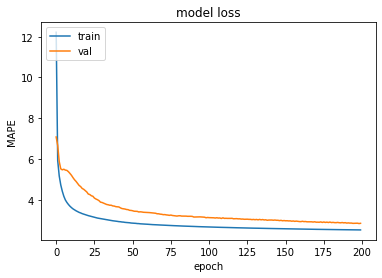

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('gru.jpeg')


MODEL LSTM

In [15]:
model_enc_LSTM = Sequential()
model_enc_LSTM.add(LSTM(64, activation='relu', input_shape=(n_steps_in, n_features)))
model_enc_LSTM.add(RepeatVector(n_steps_out))
model_enc_LSTM.add(LSTM(32, activation='relu', return_sequences=True))
model_enc_LSTM.add(TimeDistributed(Dense(2)))
model_enc_LSTM.summary()

cp_lstm = ModelCheckpoint('model_lstm', save_best_only=True, monitor='val_loss')
model_enc_LSTM.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.0001))
history2 = model_enc_LSTM.fit(X_train, y_train, batch_size = 32, shuffle=False, validation_data=(X_val, y_val), 
                              epochs=200, callbacks=[cp_lstm,EarlyStopping(monitor='val_loss', patience=20)])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 64)            0         
 or)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 5, 32)             12416     
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 2)             66        
 tributed)                                                       
                                                                 
Total params: 31,170
Trainable params: 31,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4219/4219 [===========================

4219/4219 [==============================] - 57s 14ms/step - loss: 3.0453 - val_loss: 4.4843
Epoch 34/200
4219/4219 [==============================] - 58s 14ms/step - loss: 3.0365 - val_loss: 4.4185
Epoch 35/200
4219/4219 [==============================] - 55s 13ms/step - loss: 3.0394 - val_loss: 4.4518
Epoch 36/200
4219/4219 [==============================] - 58s 14ms/step - loss: 3.0113 - val_loss: 4.4173
Epoch 37/200
4219/4219 [==============================] - 58s 14ms/step - loss: 3.0076 - val_loss: 4.3365
Epoch 38/200
4219/4219 [==============================] - 54s 13ms/step - loss: 3.0056 - val_loss: 4.3535
Epoch 39/200
4219/4219 [==============================] - 57s 14ms/step - loss: 2.9805 - val_loss: 4.2940
Epoch 40/200
4219/4219 [==============================] - 53s 13ms/step - loss: 2.9822 - val_loss: 4.3044
Epoch 41/200
4219/4219 [==============================] - 57s 14ms/step - loss: 2.9605 - val_loss: 4.2651
Epoch 42/200
4219/4219 [==============================] - 5

4219/4219 [==============================] - 54s 13ms/step - loss: 2.7325 - val_loss: 3.5592
Epoch 83/200
4219/4219 [==============================] - 54s 13ms/step - loss: 2.7362 - val_loss: 3.5840
Epoch 84/200
4219/4219 [==============================] - 57s 14ms/step - loss: 2.7247 - val_loss: 3.5350
Epoch 85/200
4219/4219 [==============================] - 55s 13ms/step - loss: 2.7300 - val_loss: 3.5659
Epoch 86/200
4219/4219 [==============================] - 59s 14ms/step - loss: 2.7184 - val_loss: 3.5082
Epoch 87/200
4219/4219 [==============================] - 54s 13ms/step - loss: 2.7236 - val_loss: 3.5377
Epoch 88/200
4219/4219 [==============================] - 57s 14ms/step - loss: 2.7123 - val_loss: 3.4887
Epoch 89/200
4219/4219 [==============================] - 54s 13ms/step - loss: 2.7158 - val_loss: 3.5200
Epoch 90/200
4219/4219 [==============================] - 58s 14ms/step - loss: 2.7050 - val_loss: 3.4752
Epoch 91/200
4219/4219 [==============================] - 5

Epoch 132/200
4219/4219 [==============================] - 57s 14ms/step - loss: 2.6043 - val_loss: 3.1070
Epoch 133/200
4219/4219 [==============================] - 54s 13ms/step - loss: 2.6091 - val_loss: 3.1453
Epoch 134/200
4219/4219 [==============================] - 53s 13ms/step - loss: 2.6009 - val_loss: 3.1176
Epoch 135/200
4219/4219 [==============================] - 53s 13ms/step - loss: 2.6065 - val_loss: 3.1215
Epoch 136/200
4219/4219 [==============================] - 57s 14ms/step - loss: 2.5980 - val_loss: 3.0936
Epoch 137/200
4219/4219 [==============================] - 54s 13ms/step - loss: 2.6029 - val_loss: 3.0956
Epoch 138/200
4219/4219 [==============================] - 57s 14ms/step - loss: 2.5928 - val_loss: 3.0807
Epoch 139/200
4219/4219 [==============================] - 54s 13ms/step - loss: 2.5968 - val_loss: 3.0871
Epoch 140/200
4219/4219 [==============================] - 58s 14ms/step - loss: 2.5910 - val_loss: 3.0789
Epoch 141/200
4219/4219 [============

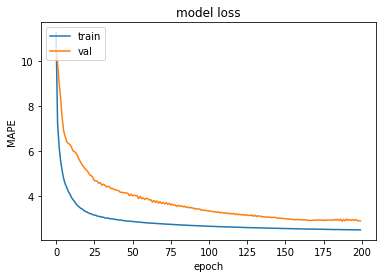

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('lstm.png')

MODEL BIDIRECTIONAL LSTM